In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
movielens_data_file_url = ("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")

movielens_zipped_file = keras.utils.get_file("ml-latest-small.zip", movielens_data_file_url, extract=False)

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

In [5]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [6]:
print("Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating))

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [7]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:])

In [8]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [9]:
history = model.fit(x=x_train,
                    y=y_train,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_val, y_val))

Epoch 1/10
1418/1418 [==============================] - 18s 11ms/step - loss: 0.6355 - val_loss: 0.6204
Epoch 2/10
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6133 - val_loss: 0.6181
Epoch 3/10
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6085 - val_loss: 0.6148
Epoch 4/10
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6078 - val_loss: 0.6143
Epoch 5/10
1418/1418 [==============================] - 10s 7ms/step - loss: 0.6076 - val_loss: 0.6153
Epoch 6/10
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6071 - val_loss: 0.6139
Epoch 7/10
1418/1418 [==============================] - 12s 9ms/step - loss: 0.6067 - val_loss: 0.6122
Epoch 8/10
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6055 - val_loss: 0.6157
Epoch 9/10
1418/1418 [==============================] - 16s 11ms/step - loss: 0.6051 - val_loss: 0.6125
Epoch 10/10
1418/1418 [==============================] - 11s 8ms/step -

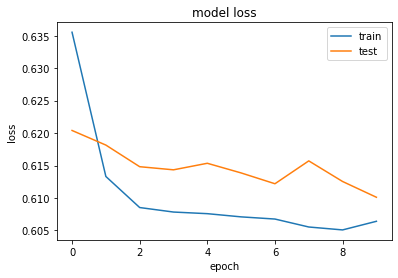

In [10]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [11]:
# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]

In [12]:
user_id

432

In [13]:
movies_watched_by_user

,userId,movieId,rating,timestamp,user,movie
67037,432,77866,4.5,1335139641,431,4730
66966,432,7306,3.0,1315243798,431,7699
67043,432,81417,4.0,1316391337,431,3624
66997,432,48516,2.5,1315244545,431,237
67033,432,72641,3.5,1315244889,431,1921
...,...,...,...,...,...,...
67028,432,69481,4.5,1335140106,431,2990
66912,432,4022,3.5,1328232706,431,1042
66918,432,4720,4.5,1316391168,431,1043
66842,432,1206,4.0,1315243615,431,71


In [14]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

In [15]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
df['movieId'].nunique(), movie_df['movieId'].nunique()

(9724, 9742)

In [19]:
movies_not_watched = df[~df["movieId"].isin(movies_watched_by_user.movieId.values)]
movies_not_watched

,userId,movieId,rating,timestamp,user,movie
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
7433,51,177,4.0,1230930634,50,535
65098,416,750,4.5,1187495659,415,722
...,...,...,...,...,...,...
6265,42,4005,4.0,996259059,41,1873
54886,364,141,4.0,869443367,363,524
76820,480,6867,4.0,1179163171,479,2240
860,6,981,3.0,845556567,5,712


In [20]:
movies_not_watched = list(
    set(movies_not_watched['movieId']).intersection(set(movie2movie_encoded.keys())))

In [22]:
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)

user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched))

In [37]:
user_movie_array

array([[ 431, 5804],
       [ 431,    1],
       [ 431,  482],
       ...,
       [ 431, 7142],
       [ 431, 2989],
       [ 431, 7869]])

In [23]:
ratings = model.predict(user_movie_array).flatten()

296/296 [==============================] - 1s 2ms/step


In [39]:
predictions = pd.DataFrame(user_movie_array)
predictions.columns = ['userId', 'MovieId']
predictions['Preds'] = ratings 
predictions.head()

,userId,MovieId,Preds
0,431,5804,0.622705
1,431,1,0.514009
2,431,482,0.405989
3,431,483,0.433924
4,431,2,0.673876


In [40]:
predictions.sort_values('Preds', ascending = False)

,userId,MovieId,Preds
990,431,2395,0.842624
983,431,69,0.836129
984,431,70,0.826851
981,431,1101,0.823966
987,431,1102,0.819929
...,...,...,...
2661,431,1695,0.277081
1241,431,1486,0.276493
2683,431,2688,0.268609
4261,431,5376,0.259183


In [ ]:
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]

In [36]:
recommended_movie_ids, ratings

([1204, 1197, 1198, 1193, 1201, 750, 3681, 1203, 1199, 1172],
 array([0.6227047 , 0.51400864, 0.40598893, ..., 0.54705703, 0.59822357,
        0.5352716 ], dtype=float32))

In [24]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (movies_watched_by_user.sort_values(by="rating", ascending=False).head(5).movieId.values)

Showing recommendations for user: 432
Movies with high ratings from user
--------------------------------


In [33]:
movies_watched_by_user.sort_values(by="rating", ascending=False).head(10)

,userId,movieId,rating,timestamp,user,movie
67029,432,71379,5.0,1316391330,431,6299
66818,432,364,5.0,1316391519,431,471
66871,432,1997,5.0,1316391091,431,2904
66865,432,1873,5.0,1316391161,431,2903
67007,432,57274,5.0,1316391360,431,5684
66992,432,45503,5.0,1316391388,431,7703
67045,432,81591,5.0,1315244863,431,1932
66971,432,8533,5.0,1315244178,431,887
66909,432,3949,5.0,1315242940,431,277
66864,432,1835,5.0,1315244490,431,2566


In [25]:
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
movie_df_rows.head()

,movieId,title,genres
322,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
1369,1873,"Misérables, Les (1998)",Crime|Drama|Romance|War
1472,1997,"Exorcist, The (1973)",Horror|Mystery
6662,57274,[REC] (2007),Drama|Horror|Thriller
7140,71379,Paranormal Activity (2009),Horror|Thriller


In [26]:
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

Lion King, The (1994) : Adventure|Animation|Children|Drama|Musical|IMAX
Misérables, Les (1998) : Crime|Drama|Romance|War
Exorcist, The (1973) : Horror|Mystery
[REC] (2007) : Drama|Horror|Thriller
Paranormal Activity (2009) : Horror|Thriller


In [27]:
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

--------------------------------
Top 10 movie recommendations
--------------------------------
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) : Comedy|War
Cinema Paradiso (Nuovo cinema Paradiso) (1989) : Drama
One Flew Over the Cuckoo's Nest (1975) : Drama
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) : Action|Adventure
Brazil (1985) : Fantasy|Sci-Fi
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
12 Angry Men (1957) : Drama
Lawrence of Arabia (1962) : Adventure|Drama|War
For a Few Dollars More (Per qualche dollaro in più) (1965) : Action|Drama|Thriller|Western
